# 03 - Cumulative Logistic Regression
The purpose of this notebook is to illustrate the cumulative logit method in R.  As of right now, there is no native way to implement this in Python.

In [1]:
options(repr.plot.width = 5, repr.plot.height = 3)
library(ggplot2)
library(VGAM)
library(dplyr)

Warning message:
: package 'ggplot2' was built under R version 3.3.3Warning message:
: package 'VGAM' was built under R version 3.3.3Loading required package: stats4
Loading required package: splines
Warning message:
: package 'dplyr' was built under R version 3.3.3Warning message:
: Installed Rcpp (0.12.11) different from Rcpp used to build dplyr (0.12.12).
Please reinstall dplyr to avoid random crashes or undefined behavior.
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Cumulative Logistic Regression
The cumulative logit is ideal for multi-class response variables that are _ordered_.  That is, the response is not a quantitative variable, but it definitely has a rank associated with it.  The cliche example is T-shirt sizes: Small, Medium, Large, etc.

There are a few parametrizations of the cumulative logit, but the predominant one is parametrized as follows:

$Y_i \sim \text{iid Mult}(1, \mathbf{\pi})$

$\gamma_j = \text{P}(\text{Category} \le j) = \pi_1 + \cdots + \pi_j$

$\text{logit}(\gamma_1 = \beta_{01} + \beta_{11} x_1 + \cdots + \beta_{p1} x_p$

$\text{logit}(\gamma_2) = \beta_{02} + \beta_{12} x_1 + \cdots + \beta_{p2} x_p$

$\cdots$

$\text{logit}(\gamma_{K-1}) = \beta_{0K-1} + \beta_{1K-1} x_1 + \cdots + \beta_{pK-1} x_p$

#### Data
The data used here is the R builtin dataset `diamonds`.  I will attempt to predict the cut quality of the diamond, which is ordinal.

In [2]:
data(diamonds)
head(diamonds)

ERROR: Error in vapply(df, class, FUN.VALUE = character(1L)): values must be length 1,
 but FUN(X[[2]]) result is length 2


  carat       cut color clarity depth table price    x    y    z
1  0.23     Ideal     E     SI2  61.5    55   326 3.95 3.98 2.43
2  0.21   Premium     E     SI1  59.8    61   326 3.89 3.84 2.31
3  0.23      Good     E     VS1  56.9    65   327 4.05 4.07 2.31
4  0.29   Premium     I     VS2  62.4    58   334 4.20 4.23 2.63
5  0.31      Good     J     SI2  63.3    58   335 4.34 4.35 2.75
6  0.24 Very Good     J    VVS2  62.8    57   336 3.94 3.96 2.48

In [3]:
dim(diamonds)

[1] 53940    10

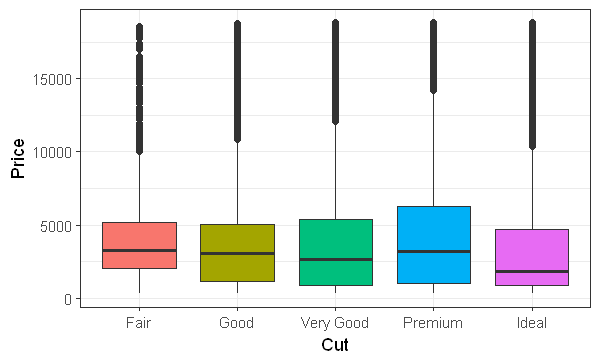

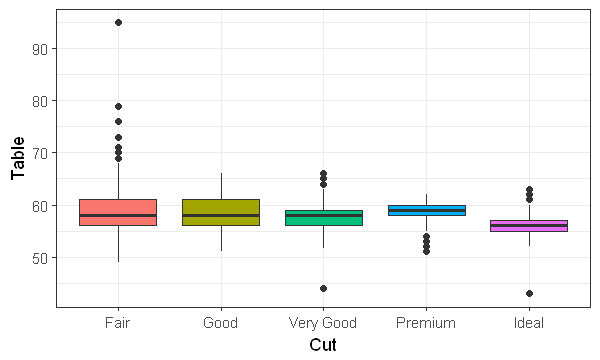

In [4]:
# This is key - I'm ordering the factor levels here, so R know what order they come in.
diamonds$cut <- factor(diamonds$cut,
                       levels = c('Fair', 'Good', 'Very Good', 'Premium', 'Ideal'),
                       ordered = TRUE)

ggplot(diamonds, aes(x = cut, y = price, fill = cut)) +
    theme_bw() +
    geom_boxplot() +
    theme(legend.position = 'none') +
    labs(x = 'Cut', y = 'Price')

ggplot(diamonds, aes(x = cut, y = table, fill = cut)) +
    theme_bw() +
    geom_boxplot() +
    theme(legend.position = 'none') +
    labs(x = 'Cut', y = 'Table')

In [5]:
# Training/test split
set.seed(1234)
n_train <- round(nrow(diamonds) * 0.67)
index_train <- sample(1:nrow(diamonds), n_train, replace = FALSE)

diamonds_train <- diamonds[index_train,]
diamonds_test <- diamonds[-index_train,]

dim(diamonds_train)

[1] 36140    10

In [6]:
# Training the model using our vglm() function
suppressWarnings({
    cum_logit <- vglm(cut ~ carat + table + price,
                  data = diamonds_train,
                  family = cumulative(par = FALSE))
})

In [7]:
summary(cum_logit)

Warning message:
In matrix.power(wz, M = M, power = 0.5, fast = TRUE): Some weight matrices have negative eigenvalues. They will be assigned NAs


Call:
vglm(formula = cut ~ carat + table + price, family = cumulative(par = FALSE), 
    data = diamonds_train)


Coefficients: 
                Estimate Std. Error   z value Pr(>|z|)    
(Intercept):1 -2.061e+01  3.486e-07 -59119524   <2e-16 ***
(Intercept):2 -1.862e+01  3.471e-07 -53656793   <2e-16 ***
(Intercept):3 -1.422e+01  3.758e-07 -37841336   <2e-16 ***
(Intercept):4 -2.769e+01  1.817e-06 -15237077   <2e-16 ***
carat:1        5.598e+00  5.259e-08 106456377   <2e-16 ***
carat:2        2.389e+00  5.118e-08  46671232   <2e-16 ***
carat:3        9.709e-01  4.816e-08  20162087   <2e-16 ***
carat:4        1.134e+00  8.360e-08  13560540   <2e-16 ***
table:1        2.622e-01  5.699e-09  46017847   <2e-16 ***
table:2        2.755e-01  5.458e-09  50470335   <2e-16 ***
table:3        2.308e-01  6.079e-09  37967139   <2e-16 ***
table:4        4.807e-01  3.305e-08  14546812   <2e-16 ***
price:1       -6.049e-04  7.293e-12 -82942963   <2e-16 ***
price:2       -2.759e-04  7.140e-12 -3863567

In [10]:
# Get matrix prediction for training/test split
yhat_train <- predict(cum_logit, diamonds_train, type = 'response')
yhat_test <- predict(cum_logit, diamonds_test, type = 'response')

head(yhat_train)

,Fair,Good,Very Good,Premium,Ideal
1,0.03776219,0.06897364,0.18771175,0.16322097,0.54233144
2,0.0295397,0.1063614,0.2383519,0.2698212,0.3559258
3,0.007530477,0.043023800,0.161815374,0.062233434,0.725396915
4,0.00979004,0.04679474,0.16419012,0.06372056,0.71550454
5,0.07244211,0.11534949,0.22304249,0.27831185,0.31085406
6,0.007679039,0.043228417,0.161927798,0.062718157,0.724446590


In [12]:
# Convert to maximum probabilities.
class_train <- apply(as.matrix(yhat_train), 1, which.max)
class_test <- apply(as.matrix(yhat_test), 1, which.max)

table(class_train)

class_train
    1     2     3     4     5 
  948   190    12 10698 24292 

In [13]:
# Convert back into 'cut' class names.
lookup_cut <- c('1' = 'Fair',
                '2' = 'Good',
                '3' = 'Very Good',
                '4' = 'Premium',
                '5' = 'Ideal')

class_train <- lookup_cut[class_train]
class_test <- lookup_cut[class_test]

table(class_train)

class_train
     Fair      Good     Ideal   Premium Very Good 
      948       190     24292     10698        12 

In [16]:
# It worked!  Let's find our classification accuracies.
train_acc = (class_train == diamonds_train$cut)

cat('Correct predictions: ', sum(train_acc), '\n')
cat('Total training obs: ', nrow(diamonds_train), '\n')
cat('Training accuracy: ', mean(train_acc))

Correct predictions:  19773 
Total training obs:  36140 
Training accuracy:  0.5471223

In [18]:
test_acc = (class_test == diamonds_test$cut)

cat('Correct predictions: ', sum(test_acc), '\n')
cat('Total testing obs: ', nrow(diamonds_test), '\n')
cat('Testing accuracy: ', mean(test_acc))

Correct predictions:  9836 
Total testing obs:  17800 
Testing accuracy:  0.5525843